## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [57]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [58]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [59]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [60]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [61]:

df.query("landing_page != 'new_page' & group == 'treatment'").count() + df.query("landing_page == 'new_page' & group != 'treatment'").count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are no rows with missing values within the dataset.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [63]:
# Creates a new dataframe (df2), that drops the rows where treatment does not match new_page or control does not match old_page.

df2=df
df2.drop(df.query("(group == 'treatment' and landing_page == 'old_page') or (group == 'control' and landing_page == 'new_page')").index, inplace=True)

In [64]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [65]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [66]:
df2[df2.user_id.duplicated()]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [67]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [68]:
df2 = df2.drop_duplicates(['user_id'])

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [69]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [70]:
control_conv = df2[df2['group'] == 'control']['converted'].mean()
control_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [71]:
treatment_conv = df2[df2['group'] == 'treatment']['converted'].mean()
treatment_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [72]:
new_page = len(df2.query("landing_page == 'new_page'"))
df_rows = df2.shape[0]
new_page / df_rows

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

To summarize the above information:
* The probability of an individual converted regardless of the page they receive was 11.9%

* Given that an individual was in the `control` group, the probability that they converted was 12%

* Given that an individual was in the `treatment` group, the probability that they converted was 11.8%

* The probability that an individual received the new page was 50%.


This information alone does not seem to be sufficient evidence to make a conclusion that the new treatment page leads to more conversions, as the conversion rates are relatively low. However, with only a 50% probability that an individual would receive the new page, and not yet exploring how many of these users who actually received the new page converted, we need a more robust analysis before we can make a definitive statement on whether the new page is preferred over the old. 




<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}: p_{old} \le p_{new}$

$H_{1}: p_{new} > p_{old}$



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [73]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [74]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [75]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [76]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [77]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17347

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [78]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17543

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [79]:
(new_page_converted/n_new) - (old_page_converted/n_old)

-0.0013787577494455971

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [80]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

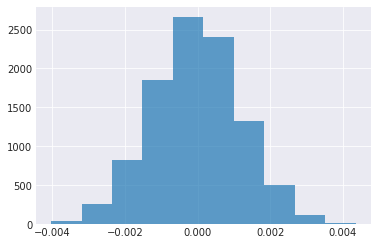

In [81]:
plt.hist(p_diffs, alpha=.7);

This histogram looks as expected, with a normal distribution.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [82]:
actual_diffs = treatment_conv - control_conv
p_val = (p_diffs > actual_diffs).mean()
p_val

0.89839999999999998

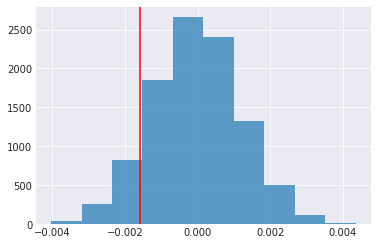

In [83]:
plt.hist(p_diffs, alpha=.7);
plt.axvline(x=actual_diffs, color='red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part `j`, we have calculated the proportion of the simulated difference in means, `p_diffs` that is greater than the actual difference in means calculated from the dataset of the proportion of conversion rates between the 'treatment' and 'control' groups.

In scientific studies, this value would be referred to as the `p value`, which we found to be 0.91. The `p value`, or probability value, is the probability of observing your stastic, or one more extreme in favor of the alternative, if the null hupothesis is true. The `p value` is a number between 0 and 1 where a value of ≤ 0.05 indicates that there is strong evidence against the null hypotheis, thus suggesting the null hypothesis should be rejected, and a value of > 0.05 would suggest that there is strong evidence for the null hypothesis being true.

In `Part j`, we found the `p value` to be 0.91, which would indicate that there is strong statistical evidence for the null hypothesis, suggesting we accept the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [84]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [85]:
df_treatment = df2.query('group == "treatment"').shape[0]
df_control = df2.query('group == "control"').shape[0]

In [86]:
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').shape[0]
convert_new = df2.query('group == "treatment" and converted == 1').shape[0]
n_old = df_control
n_new = df_treatment

print('convert_old: {}'.format(convert_old))
print('convert_new: {}'.format(convert_new))
print('n_old: {}'.format(n_old))
print('n_new: {}'.format(n_new))

convert_old: 17489
convert_new: 17264
n_old: 145274
n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [87]:
zscore, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
zscore, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

z-Score measures how many standard deviations a value is from the mean of a group of values, meaning the `p value` lies between the first and second standard deviations above the mean. The `p value` returned from the ztest is 0.905, which is extremely close to our `p value` of 0.91 from `Part j`. As our null hypothesis is comparing against a Type I error rate of 5%, the z-score also suggests we should accept the null hypothesis that the old page is equally as good, if not better, than the new page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since we will be primarily examining conversion rate, which is a categorical dependent variable, logistic regression appears to be the best model for this case.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [88]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [89]:
df2['intercept'] = 1
df2[['g_drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('g_drop', axis=1, inplace=True)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [90]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [91]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:47:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

The `p value` associated with `ab_page` above is 0.19, whereas in **Part II** we found the `p value` to be 0.904. The reason for this difference is that we are testing two different hypotheses in two different ways. In **Part II**, we were trying to determine if the old page increased conversion rates. This is a one-tailed test, meaning that our alpha of 0.05 is entirely on one tail of our distribution, and we have inequality signs in our hypothesis. 

In the above section, we are examining the relationship of which page a user receives and its associated impact on conversion rates, which we can determine by the `p value` is that there is none. This is a two-tailed test, which splits the alpha of 0.05 in half, placing each half at each tail of the distribution, and we can determine that the new page is equal to the old page, which is the null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There are many other things that we could, and should, consider in this regression model. With the data at hand, we are only aware of whether a user received the old page or new page, and whether or not the user converted. We have date and time information that could potentially be useful in the model to determine if users viewing the pages at certain times, or within certain months, were more or less likely to convert.  Other information that would be benefit this is analysis is location data, and frequency of the user. Where were users located when this data was collected and are they a first-time visitor to the site or a frequent user? 

More data would allow us to ensure we're not looking at a Simpson's Paradox situation, where individual data appears to support one hypothesis, but when the data is combined, it shows no correlation or the opposite. 

The downside to adding additional information is that we may experience a diluted relationship between two of our variables. There may be a very strong relationship between two variables, but as we add additional variables, this relationship can become diluted and skew our correlation coefficient.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

In [92]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [93]:
df3 = df2.set_index('user_id').join(countries.set_index('user_id'))
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [94]:
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [95]:
df3[['US','UK','CA']]=pd.get_dummies(df3['country'])

In [96]:
df3['US_ab_page'] = df3['US'] * df3['ab_page']
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']

In [97]:
df3.drop(['UK'], axis=1, inplace=True)
df3.head(30)

,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA,US_ab_page,CA_ab_page
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,1,0,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,1,0
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,1,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,0,0,0


In [98]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'CA', 'CA_ab_page', 'US', 'US_ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 07 Dec 2019   Pseudo R-squ.:               3.482e-05
Time:                        16:47:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA             0.0057      0.019      0.306      0.760      -0.031       0.043
CA_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
US            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

In [99]:
np.exp(0.0108), np.exp(0.057), np.exp(-0.0314), np.exp(-0.0118), np.exp(-0.0783)

(1.010858530520097,
 1.0586558103955002,
 0.96908786039450134,
 0.98826934696725466,
 0.92468697883481343)

In [100]:
1/np.exp(-0.0314), 1/np.exp(-0.118), 1/np.exp(-0.0783)

(1.0318981806179213, 1.1252441113673424, 1.0814470441230692)

In the above cell we calculated the multiplicative change in odds of the conversion occurring. The model found that:
* With each unit decrease in new_page, a user from CA was 1.03x more likely to convert to the new page, all else constant.
* With each unit decrease in new_page, a user from the US was 1.08x more likely to convert to the new page, all else constant.
* All `p values` are greater than the alpha of 0.05, which would suggest we should accept the null hypothesis of the new page is equal to the old page, which matches with the low conversion rates we see above. With these results from our model, it would not appear that a user's country has an impact on conversion.

These results show that the new page does not demonstrate a significant difference in conversion rates with the new page. We can reject the alternative hypothesis that the new page is definitively better at converting users than the old page, as this proves to be inaccurate given the data from this dataset. Given these results, it would be recommended to not put the new page into production at this time. 